<a href="https://colab.research.google.com/github/DajeanArcila/biblioteca_pandas/blob/main/ML_dolar_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse

register_matplotlib_converters()
%matplotlib inline

# Cargar datos
dataset = pd.read_excel('/content/BaseDeDatosLista aaaaaaaaaaaaaaa.xlsx')

# Asegurarse de que la columna de fecha esté en formato datetime
dataset['Data'] = pd.to_datetime(dataset['Data'])
print('+++++++++++++++++++++++++++++++++++++++++')
# Verificar el rango de fechas
print(' A data minima e:',dataset['Data'].min(), 'e a data maxima e?' ,dataset['Data'].max())
print('+++++++++++++++++++++++++++++++++++++++++')

+++++++++++++++++++++++++++++++++++++++++
 A data minima e: 2021-01-01 00:00:00 e a data maxima e? 2024-04-30 00:00:00
+++++++++++++++++++++++++++++++++++++++++


In [15]:
# Eliminar columnas no deseadas
dataset = dataset.drop(columns=['Var%', 'DATA'])  # Reemplaza 'Column7' y 'Column6' por los nombres reales

# Calcular la media
dataset['Mean'] = (dataset['Mínima'] + dataset['Máxima']) / 2

# Desplazar la columna 'Mean' para crear la columna 'Actual'
steps = -1
dataset['Actual'] = dataset['Mean'].shift(steps)

# Eliminar filas con valores NaN
dataset = dataset.dropna()

# Asignar la columna de fecha como índice
dataset.set_index('Data', inplace=True)

# Escalar los datos
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset[['Mínima', 'Máxima', 'Abertura', 'Último', 'RESERVAS', 'Vol/', 'Mean']])
X = pd.DataFrame(scaled_input, index=dataset.index, columns=['Mínima', 'Máxima', 'Abertura', 'Último', 'RESERVAS', 'Vol/', 'Mean'])

sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(dataset[['Actual']])
y = pd.DataFrame(scaled_output, index=dataset.index, columns=['Actual'])

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(dataset) * 0.7)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

# Entrenar el modelo SARIMAX
model = SARIMAX(train_y, exog=train_X, order=(0, 1, 1), enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()

# Realizar predicciones
predictions = results.predict(start=train_size, end=len(dataset)-1, exog=test_X)

# Invertir la escala de las predicciones
predictions = sc_out.inverse_transform(predictions.values.reshape(-1, 1))
actual = sc_out.inverse_transform(test_y.values.reshape(-1, 1))

# Crear DataFrame para las predicciones y valores reales
pred_df = pd.DataFrame(predictions, index=test_X.index, columns=['Pred'])
pred_df['Actual'] = actual

# Graficar los resultados
plt.figure(figsize=(20, 8))
plt.plot(pred_df.index, pred_df['Actual'], label='Actual', color='blue')
plt.plot(pred_df.index, pred_df['Pred'], label='Pred', color='red')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Predicción del precio del dólar')
plt.show()


KeyError: "['Var%', 'DATA'] not found in axis"

In [13]:
# Calcular el RMSE
error = rmse(pred_df['Pred'], pred_df['Actual'])
print(f"RMSE: {error}")

# Calcular el porcentaje de error
mean_actual = pred_df['Actual'].mean()
percentage_error = (error / mean_actual) * 100
print(f"Porcentaje de error: {percentage_error:.2f}%")


RMSE: 0.04116180095938021
Porcentaje de error: 0.76%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


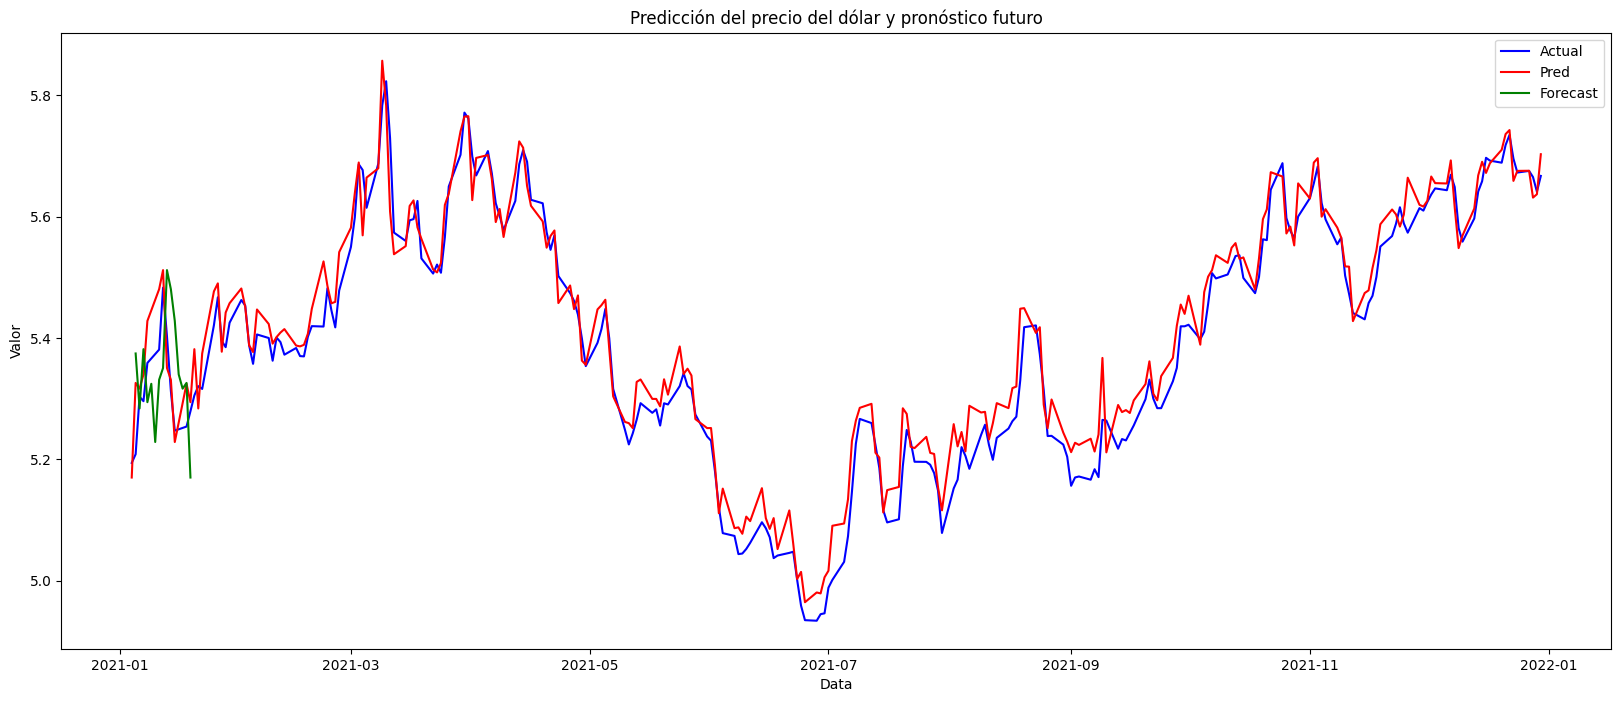

            Forecast
2021-01-05  5.374409
2021-01-06  5.283796
2021-01-07  5.381518
2021-01-08  5.294133
2021-01-09  5.324427
2021-01-10  5.228508
2021-01-11  5.331070
2021-01-12  5.350434
2021-01-13  5.511801
2021-01-14  5.480346
2021-01-15  5.427993
2021-01-16  5.339889
2021-01-17  5.316430
2021-01-18  5.325892
2021-01-19  5.169952


In [14]:

# Pronóstico para los próximos 15 días
forecast_steps = 15
future_dates = pd.date_range(start=dataset.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Realizar predicciones futuras
future_predictions = results.get_forecast(steps=forecast_steps, exog=test_X.iloc[-forecast_steps:])
forecast = sc_out.inverse_transform(future_predictions.predicted_mean.values.reshape(-1, 1))

# Crear DataFrame para las predicciones futuras
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])

# Graficar las predicciones futuras
plt.figure(figsize=(20, 8))
plt.plot(pred_df.index, pred_df['Actual'], label='Actual', color='blue')
plt.plot(pred_df.index, pred_df['Pred'], label='Pred', color='red')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='green')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Predicción del precio del dólar y pronóstico futuro')
plt.show()

# Mostrar las predicciones futuras
print(forecast_df)